## Mod 5 Lecture 5 Code-Along:  Cohorts & Retention 

### Why this activity?
This hands-on exercise connects directly to today’s lecture on **Cohorts & Retention**. You’ll build a **cohort retention matrix** that shows whether new users keep coming back over time. This is core to understanding product “stickiness” and whether changes are helping or hurting.

### Goals (you will be able to…)
1. Define **cohorts** by a shared start event (signup month).
2. Compute **retention** across months since signup.
3. Visualize and interpret a **cohort matrix** (table of retention rates).
4. Explain cohort differences to stakeholders in plain language.

### Interview practice (be ready to answer)
- **Q1:** Why is a cohort retention chart more useful than just looking at MAU (monthly active users)?
- **Q2:** Day-7 retention suddenly dropped from 40% → 20% for a new cohort. What do you investigate first?


## Step 1 — Create a small user activity dataset
We’ll use a tiny example so you can see the full pipeline end-to-end.


In [1]:
import pandas as pd

data = {
    "user_id":       [1, 2, 1, 3, 2, 1, 4, 3],
    "activity_date": ["2023-01-05", "2023-01-10", "2023-02-04", "2023-02-15",
                      "2023-02-16", "2023-03-01", "2023-03-20", "2023-03-25"]
}
df = pd.DataFrame(data)
#Convert to datetime 
df["activity_date"] = pd.to_datetime(df['activity_date'])
df.head()



,user_id,activity_date
0,1,2023-01-05
1,2,2023-01-10
2,1,2023-02-04
3,3,2023-02-15
4,2,2023-02-16


## Step 2 — Define cohorts by signup month
We’ll:
1) Find each user’s **first activity** date (treat as signup).  
2) Convert that to a **cohort month** (e.g., 2023-01).

In [8]:
# First activity per user (treat as signup date)
#df["signup_date"] = df.groupby(df['user_id']).transform(min)
# Cohort month (Period[M])
df["cohort"] = df['signup_date'].dt.to_period('M')
df[["user_id", "activity_date", "signup_date", "cohort"]].head(8)


,user_id,activity_date,signup_date,cohort
0,1,2023-01-05,2023-01-05,2023-01
1,2,2023-01-10,2023-01-10,2023-01
2,1,2023-02-04,2023-01-05,2023-01
3,3,2023-02-15,2023-02-15,2023-02
4,2,2023-02-16,2023-01-10,2023-01
5,1,2023-03-01,2023-01-05,2023-01
6,4,2023-03-20,2023-03-20,2023-03
7,3,2023-03-25,2023-02-15,2023-02


## Step 3 — Calculate retention by months since signup
We’ll:
1) Compute **month_number** = months since cohort start.  
2) Count **unique active users** by (cohort, month_number).  
3) Pivot to a **cohort matrix**: rows = cohorts, columns = months since signup.  
4) Divide each row by **cohort size** (Month 0) to get a retention rate.

In [10]:
# Months since signup (cohort)

df["month_number"] = (df['activity_date'].dt.to_period('M') - df['cohort']).apply(lambda x: x.n)

# Unique active users per (cohort, month_number)
cohort_data = (df.groupby(['cohort', 'month_number'])['user_id'].nunique().reset_index())

# Pivot: rows = cohort, columns = months since signup
cohort_pivot = cohort_data.pivot(index='cohort', columns='month_number', values='user_id')

# Cohort size = Month 0 users
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

retention_matrix


month_number,0,1,2
cohort,,,
2023-01,1.0,1.0,0.5
2023-02,1.0,1.0,NaN
2023-03,1.0,NaN,NaN


## Step 4 — Format as % and interpret
We’ll convert to percents for a stakeholder-friendly view.  
Then write 2–3 sentences interpreting a meaningful difference between cohorts.

In [11]:
retention_pct = (retention_matrix.round(2) * 100)
retention_pct.fillna("", inplace=True)
retention_pct


/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_43664/910410490.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  retention_pct.fillna("", inplace=True)


month_number,0,1,2
cohort,,,
2023-01,100.0,100.0,50.0
2023-02,100.0,100.0,
2023-03,100.0,,


### Sample Interpretation
- The **Jan 2023** cohort retains better at Month 1 than the **Feb 2023** cohort.  
- A likely explanation is a **product or onboarding change** made in February that increased early churn, or a **marketing source** shift that brought in lower-intent users.  
- Next, I’d track **onboarding completion** and **first-week engagement** for each cohort and compare to see where the friction starts.


### Optional (for now):  Visualize It!

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_43664/2684061264.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pct = pct.replace("", np.nan).astype(float).fillna(0.0)


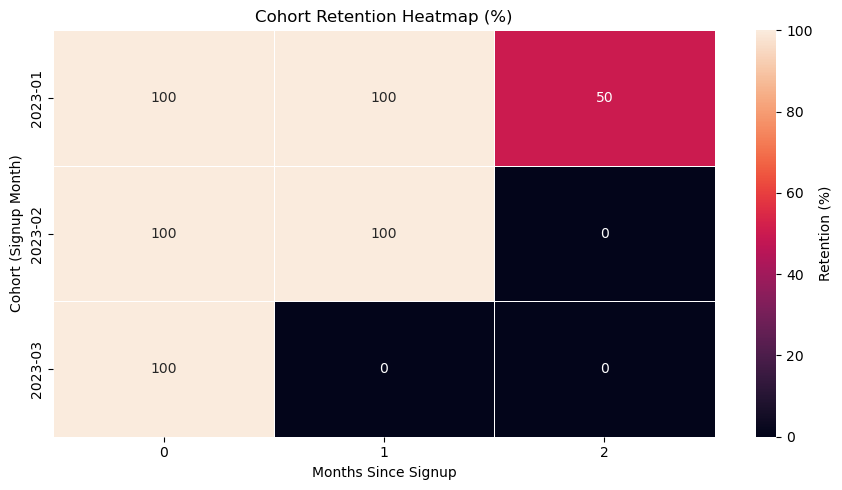

In [12]:
#RUN THIS CELL WITHOUT CHANGES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric 0–100 matrix
pct = retention_pct.copy()
pct = pct.replace("", np.nan).astype(float).fillna(0.0)
pct = pct.sort_index(axis=0).sort_index(axis=1)

plt.figure(figsize=(9, 5))
ax = sns.heatmap(
    pct,
    annot=True,            # show numbers in cells
    fmt=".0f",             # no decimals
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Retention (%)"},
    vmin=0, vmax=100
)
ax.set_title("Cohort Retention Heatmap (%)")
ax.set_xlabel("Months Since Signup")
ax.set_ylabel("Cohort (Signup Month)")
plt.tight_layout()
plt.show()
